
# Lab 1: Базові алгоритми класифікації з використанням Scikit-learn  
**Датасет:** Netflix Movies and TV Shows (Kaggle)  

1) Завантаження даних, вивід назв колонок та розміру датасета.  
2) Обробка пропусків.  
3) Візуалізація: heatmap кореляцій, гістограми та boxplot-и відносно цільової змінної.  
4) Нормалізація даних.  
5) Навчання kNN, Decision Tree, SVM, Random Forest, AdaBoost з підбором гіперпараметрів, вибір найкращої моделі, вивід `classification_report` та `confusion_matrix`.


In [18]:

import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

pd.set_option("display.max_columns", 100)
plt.rcParams["figure.figsize"] = (8, 5)


## 1) Завантаження даних, вивід назв колонок і розміру датасета

In [8]:

csv_path = "netflix_titles.csv.csv"

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Не знайдено {csv_path}. Завантажте файл з Kaggle або змініть шлях у змінній csv_path.")

df = pd.read_csv(csv_path)
print("Назви колонок:")
print(list(df.columns))
print("\nРозмір датасета (rows, cols):", df.shape)
df.head()


Назви колонок:
['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']

Розмір датасета (rows, cols): (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## 2) Опрацювання пропусків

In [9]:

missing_summary = df.isna().sum().sort_values(ascending=False)
print("Кількість пропусків у колонках:")
print(missing_summary)

# Для класифікації візьмемо цільову змінну 'type' (Movie / TV Show)
# Видалимо рядки без 'type' (якщо такі є)
df = df.dropna(subset=["type"]).copy()

# Базова інженерія ознак:
# - release_year (numeric)
# - duration_minutes (numeric; для TV Show — кількість сезонів)
# - num_cast, num_countries, num_genres (numeric counts)
# - rating (категоріальна — безпечно One-Hot)
# - date_added -> year_added, month_added
def parse_duration(val):
    if pd.isna(val):
        return np.nan
    s = str(val).lower().strip()
    # приклади: "90 min", "2 Seasons", "1 Season"
    if "min" in s:
        m = re.findall(r"(\d+)", s)
        return float(m[0]) if m else np.nan
    if "season" in s:
        m = re.findall(r"(\d+)", s)
        return float(m[0]) if m else np.nan
    return np.nan

def safe_count_split(x, sep=","):
    if pd.isna(x) or not str(x).strip():
        return 0
    return len([p for p in str(x).split(sep) if p.strip()])

def parse_date_added(x):
    if pd.isna(x) or not str(x).strip():
        return (np.nan, np.nan)
    try:
        d = pd.to_datetime(x)
        return (d.year, d.month)
    except Exception:
        return (np.nan, np.nan)

df["duration_num"] = df["duration"].apply(parse_duration)
df["num_cast"] = df["cast"].apply(safe_count_split)
df["num_countries"] = df["country"].apply(safe_count_split)
df["num_genres"] = df["listed_in"].apply(safe_count_split)

year_month = df["date_added"].apply(parse_date_added)
df["year_added"] = [ym[0] for ym in year_month]
df["month_added"] = [ym[1] for ym in year_month]

# Оберемо підмножину ознак
feature_cols_num = ["release_year", "duration_num", "num_cast", "num_countries", "num_genres", "year_added", "month_added"]
feature_cols_cat = ["rating"]

# Прості імп’ютери: числові пропуски -> медіани, категоріальні -> 'Unknown'
for c in feature_cols_num:
    if c not in df.columns:
        df[c] = np.nan
    df[c] = pd.to_numeric(df[c], errors="coerce")
    df[c] = df[c].fillna(df[c].median())

for c in feature_cols_cat:
    if c not in df.columns:
        df[c] = "Unknown"
    df[c] = df[c].fillna("Unknown")

# Ціль
y = (df["type"].astype(str).str.strip()).values  # "Movie"/"TV Show"

X_num = df[feature_cols_num].copy()
X_cat = df[feature_cols_cat].copy()

print("Розмірність числових ознак:", X_num.shape)
print("Розмірність категоріальних ознак:", X_cat.shape)


Кількість пропусків у колонках:
director        2634
country          831
cast             825
date_added        10
rating             4
duration           3
show_id            0
type               0
title              0
release_year       0
listed_in          0
description        0
dtype: int64
Розмірність числових ознак: (8807, 7)
Розмірність категоріальних ознак: (8807, 1)


## 3) Візуалізація даних

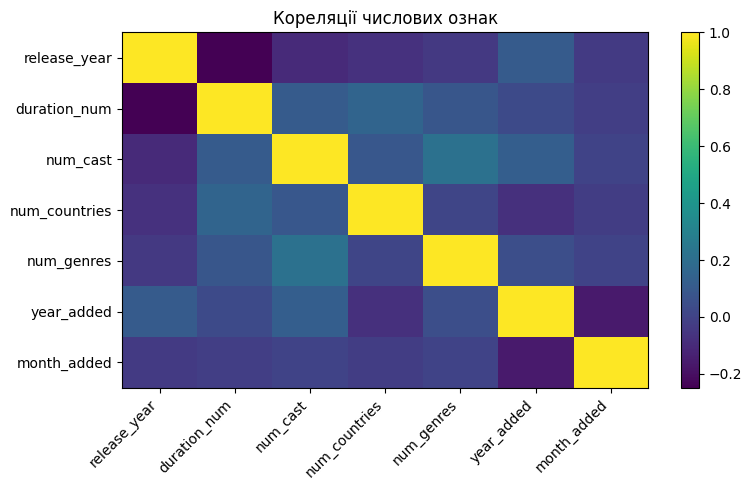

In [10]:

# 3.1 Heatmap кореляцій для числових ознак (matplotlib, без seaborn)
corr = X_num.corr(numeric_only=True)
fig, ax = plt.subplots()
im = ax.imshow(corr.values, aspect='auto')
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)
plt.title("Кореляції числових ознак")
plt.colorbar(im)
plt.tight_layout()
plt.show()


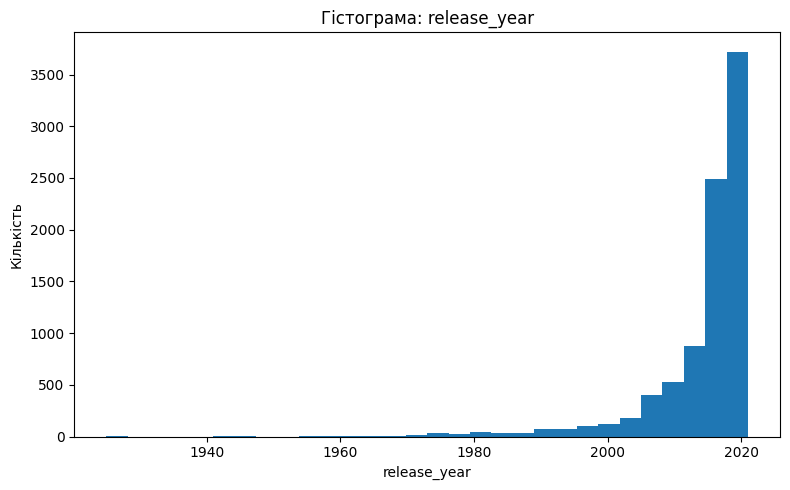

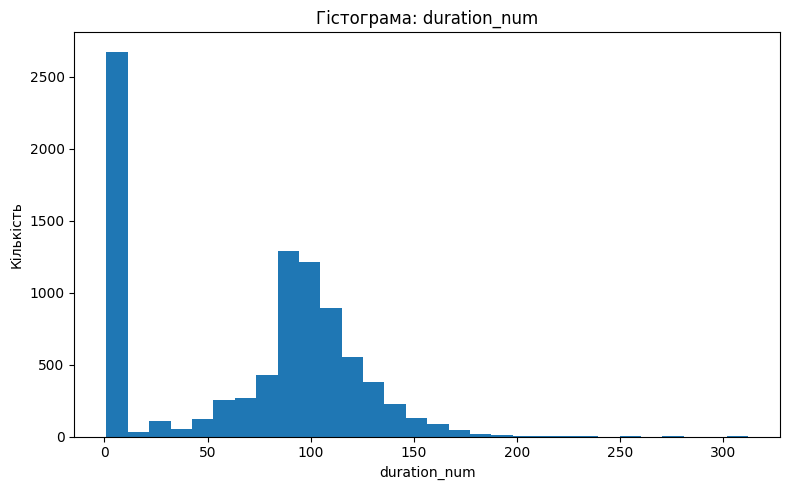

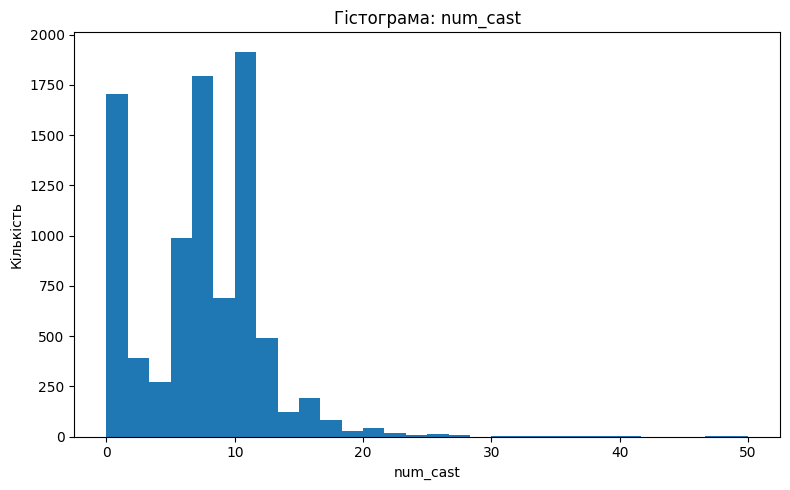

In [11]:

# 3.2 Гістограми розподілу для кількох ознак
for col in ["release_year", "duration_num", "num_cast"]:
    plt.figure()
    plt.hist(X_num[col].values, bins=30)
    plt.xlabel(col)
    plt.ylabel("Кількість")
    plt.title(f"Гістограма: {col}")
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_21724/2774324896.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_movie, data_tv], labels=["Movie", "TV Show"])


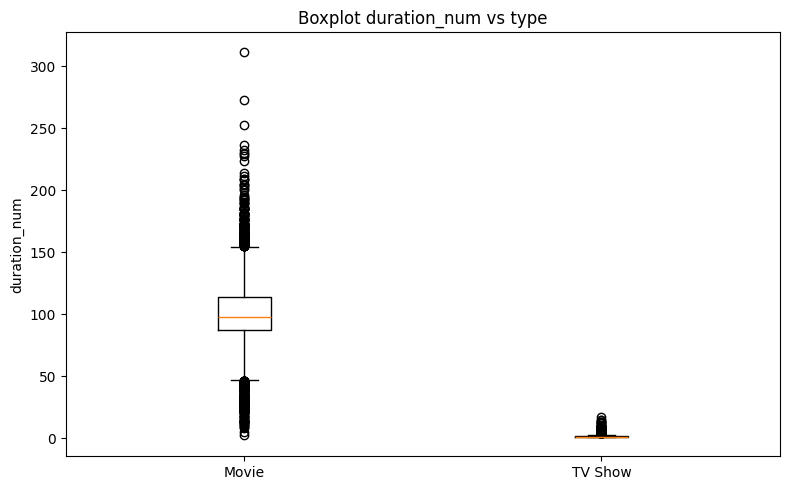

/tmp/ipykernel_21724/2774324896.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_movie, data_tv], labels=["Movie", "TV Show"])


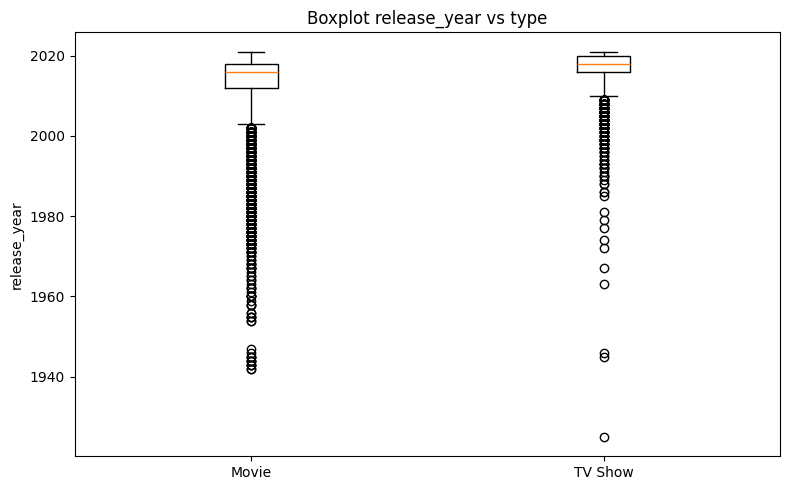

/tmp/ipykernel_21724/2774324896.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_movie, data_tv], labels=["Movie", "TV Show"])


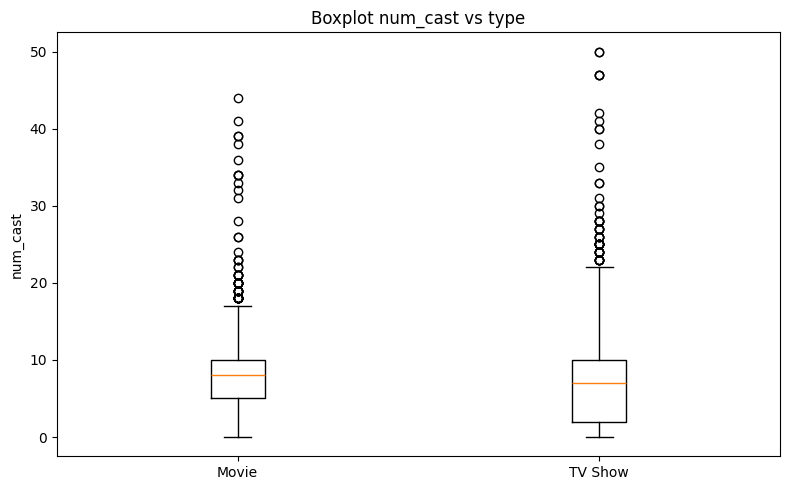

In [12]:

# 3.3 Boxplot ознак відносно цільової змінної (Movie / TV Show)
# Візьмемо 3 ознаки для наочності
plot_cols = ["duration_num", "release_year", "num_cast"]
for col in plot_cols:
    plt.figure()
    data_movie = df[df["type"]=="Movie"][col].values
    data_tv = df[df["type"]=="TV Show"][col].values
    plt.boxplot([data_movie, data_tv], labels=["Movie", "TV Show"])
    plt.ylabel(col)
    plt.title(f"Boxplot {col} vs type")
    plt.tight_layout()
    plt.show()


## 4) Нормалізація даних

In [15]:

from sklearn.preprocessing import OneHotEncoder

# Побудуємо загальний дизайн-матриці через ColumnTransformer
numeric_features = feature_cols_num
categorical_features = feature_cols_cat

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# Тренувально-тестовий спліт
X = pd.concat([X_num, X_cat], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (7045, 8)  Test shape: (1762, 8)


## 5) Навчання класифікаторів і підбір гіперпараметрів

In [16]:

# Заготовка пайплайна: preprocessing + model
def make_pipe(model):
    return Pipeline(steps=[("prep", preprocess), ("model", model)])

results = {}

# 5.1 kNN
knn_param_grid = {
    "model__n_neighbors": [3, 5, 7, 9, 11],
    "model__weights": ["uniform", "distance"],
    "model__metric": ["minkowski"]
}
knn_grid = GridSearchCV(make_pipe(KNeighborsClassifier()), knn_param_grid, cv=5, n_jobs=-1, scoring="accuracy")
knn_grid.fit(X_train, y_train)
results["kNN"] = knn_grid
print("kNN best:", knn_grid.best_params_, " | best score:", knn_grid.best_score_)

# 5.2 Decision Tree
dt_param_grid = {
    "model__max_depth": [None, 5, 10, 20, 30],
    "model__min_samples_leaf": [1, 2, 5, 10],
    "model__criterion": ["gini", "entropy"]
}
dt_grid = GridSearchCV(make_pipe(DecisionTreeClassifier(random_state=42)), dt_param_grid, cv=5, n_jobs=-1, scoring="accuracy")
dt_grid.fit(X_train, y_train)
results["DecisionTree"] = dt_grid
print("DecisionTree best:", dt_grid.best_params_, " | best score:", dt_grid.best_score_)

# 5.3 SVM (RBF): GridSearch по C і gamma
svm_param_grid = {
    "model__C": [0.1, 1, 3, 10, 30, 100],
    "model__gamma": ["scale", 0.001, 0.01, 0.1, 1]
}
svm_grid = GridSearchCV(make_pipe(SVC(kernel="rbf", probability=True, random_state=42)), svm_param_grid, cv=5, n_jobs=-1, scoring="accuracy")
svm_grid.fit(X_train, y_train)
results["SVM"] = svm_grid
print("SVM best:", svm_grid.best_params_, " | best score:", svm_grid.best_score_)

# 5.4 Random Forest
rf_param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20, 30],
    "model__min_samples_leaf": [1, 2, 5]
}
rf_grid = GridSearchCV(make_pipe(RandomForestClassifier(random_state=42)), rf_param_grid, cv=5, n_jobs=-1, scoring="accuracy")
rf_grid.fit(X_train, y_train)
results["RandomForest"] = rf_grid
print("RandomForest best:", rf_grid.best_params_, " | best score:", rf_grid.best_score_)

# 5.5 AdaBoost (з простим деревом як базовим оцінювачем за замовчуванням)
ab_param_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__learning_rate": [0.01, 0.1, 1.0]
}
ab_grid = GridSearchCV(make_pipe(AdaBoostClassifier(random_state=42)), ab_param_grid, cv=5, n_jobs=-1, scoring="accuracy")
ab_grid.fit(X_train, y_train)
results["AdaBoost"] = ab_grid
print("AdaBoost best:", ab_grid.best_params_, " | best score:", ab_grid.best_score_)

# Вибір найкращої моделі за CV-accuracy
best_name, best_grid = None, None
best_score = -np.inf
for name, grid in results.items():
    if grid.best_score_ > best_score:
        best_score = grid.best_score_
        best_name, best_grid = name, grid

print(f"\nНайкраща модель за CV: {best_name} з точністю {best_score:.4f}")


kNN best: {'model__metric': 'minkowski', 'model__n_neighbors': 9, 'model__weights': 'distance'}  | best score: 0.9795599716110717
DecisionTree best: {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 5}  | best score: 0.9984386089425124
SVM best: {'model__C': 100, 'model__gamma': 0.01}  | best score: 0.9985805535841022
RandomForest best: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 100}  | best score: 0.9985805535841022
AdaBoost best: {'model__learning_rate': 1.0, 'model__n_estimators': 100}  | best score: 0.9985805535841022

Найкраща модель за CV: SVM з точністю 0.9986


=== Classification Report (Test) ===
              precision    recall  f1-score   support

       Movie       1.00      1.00      1.00      1227
     TV Show       1.00      1.00      1.00       535

    accuracy                           1.00      1762
   macro avg       1.00      1.00      1.00      1762
weighted avg       1.00      1.00      1.00      1762

=== Confusion Matrix (Test) ===
[[1227    0]
 [   0  535]]


<Figure size 800x500 with 0 Axes>

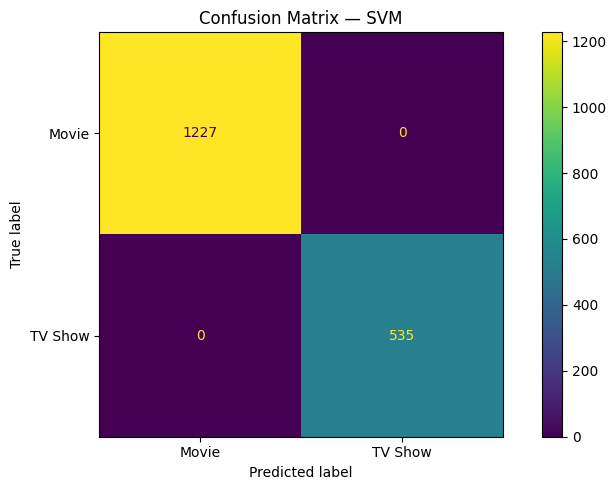

In [19]:

best_model = best_grid.best_estimator_
y_pred = best_model.predict(X_test)

print("=== Classification Report (Test) ===")
print(classification_report(y_test, y_pred))

print("=== Confusion Matrix (Test) ===")
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
print(cm)

# Візуалізація матриці невідповідностей
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(values_format='d')
plt.title(f"Confusion Matrix — {best_name}")
plt.tight_layout()
plt.show()



### Додатково
У цьому ноутбуці як ціль використано `type` (Movie / TV Show).  
Ознаки побудовано з числових полів та простого парсингу текстових колонок (rating, duration, cast, listed_in, date_added).  
